In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
#import random 

In [27]:
import pandas as pd
df = pd.read_csv("ie.csv", delimiter=',', skiprows=0, low_memory=False)
df.iloc[:,0:3]

,city,lat,lng
0,Dublin,53.3425,-6.2658
1,Cork,51.9000,-8.4731
2,Galway,53.2729,-9.0418
3,Limerick,52.6653,-8.6238
4,Waterford,52.2583,-7.1190
5,Drogheda,53.7139,-6.3503
6,Dún Dealgan,54.0090,-6.4049
7,Swords,53.4597,-6.2181
8,Tralee,52.2675,-9.6962
9,Carlow,52.8306,-6.9317


In [18]:
model = AbstractModel()
model.N =Param ( mutable=True)
model.i = Set()
model.j = Set(initialize=model.i)

def rule_init(model,i):
    return random.uniform(0,1)

model.xp =Param (model.i, default=rule_init, mutable=True) 
model.yp =Param (model.i, default=rule_init, mutable=True)
model.r =Param (default=0.85, mutable=True)


def rule_init2D(model,i,j):
    return sqrt((model.xp[i]-model.xp[j])**2+(model.yp[i]-model.yp[j])**2)

model.d  =Param  (model.i,model.j, initialize=rule_init2D, mutable=True)

model.x = Var(model.i,model.j, initialize=0,within=Binary)
model.u = Var(model.i, bounds=(0,model.N), within=NonNegativeReals)

def rule_eq2(model,i):
    return sum(model.x[i,j] for j in model.j if i!=j ) ==1
model.eq2 = Constraint(model.i,rule=rule_eq2)

def rule_eq3(model,j):
    return sum(model.x[i,j] for i in model.i if i!=j ) ==1
model.eq3 = Constraint(model.j,rule=rule_eq3)

def rule_eq4(model,i,j):
        if i!=j and j >1 :
            return model.u[i]+model.x[i,j]<= model.u[j]+ (model.N-1)*(1- model.x[i,j])
        else:
            return Constraint.Skip
model.eq4 = Constraint(model.i,model.j,rule=rule_eq4)

def rule_eq5(model,i,j):
        if (i!=j ):
            return model.x[j,i]+model.x[i,j]<= 1
        else:
            return Constraint.Skip
model.eq5 = Constraint(model.i,model.j,rule=rule_eq5)

def rule_of(model):
    return sum(model.d[i,j]*model.x[i,j] for i in model.i for j in model.j if i!=j )
    
model.obj = Objective(rule=rule_of, sense=minimize)

In [22]:
#model.N=43
opt = SolverFactory('glpk')
opt.options["mipgap"] = 0.05
instance = model.create_instance('Ireland.dat')
#instance = model.create_instance('AE.dat')

results = opt.solve(instance) # solves and updates instance

if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  results.solver.status)

Solver Status: ok


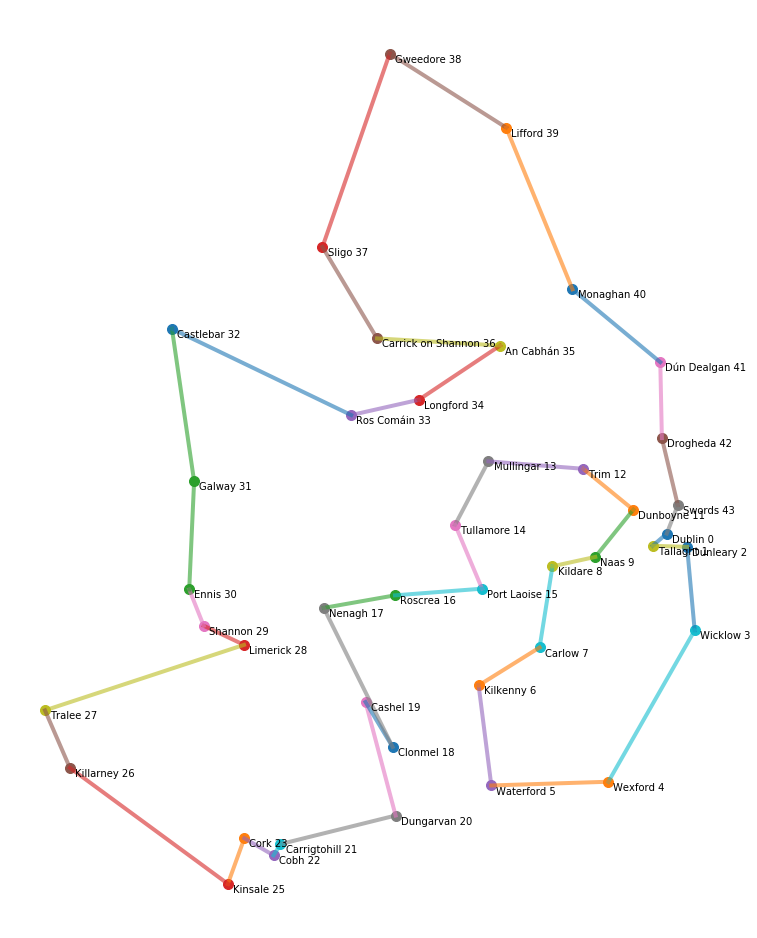

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3488
  Number of variables: 1765
  Number of nonzeros: 11932
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: feasible
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.9418931007385254
# ----------------------------------------------------------
#   Solution Information
# ------------------------------

In [24]:
fig = plt.figure(figsize=(13,17))

for i in instance.i:
    for j in instance.j:
        if i!=j and value(instance.x[i,j])>0.1:
            plt.plot([value(instance.xp[i]),value(instance.xp[j])],[value(instance.yp[i]),value(instance.yp[j])],lw=4, alpha=0.6)
            plt.scatter(value(instance.xp[i]),value(instance.yp[i]),s=100, alpha=1)
            plt.text(value(instance.xp[j])+2,value(instance.yp[j])-3, str(df.loc[j-1,'city'] ) + ' '+str(int(value(instance.u[j]) )  ) )  
            
plt.grid()
plt.savefig("Ireland.png",transparent=True)
plt.axis('off')
plt.show()
results.write(num=1)

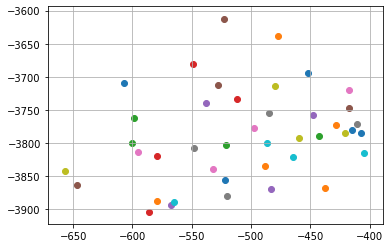

In [6]:
for i in instance.i:
    plt.scatter(value(instance.xp[i]),value(instance.yp[i]))   
plt.grid()

In [7]:
model.N=40
instance = model.create_instance()
results = opt.solve(instance) # solves and updates instance

    solver failure.


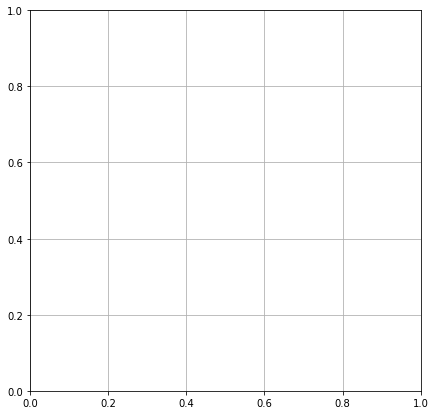

In [8]:
fig = plt.figure(figsize=(7,7))
for i in instance.i:
    for j in instance.j:
        if i!=j and value(instance.x[i,j])>0.1:
            plt.plot([value(instance.xp[i]),value(instance.xp[j])],[value(instance.yp[i]),value(instance.yp[j])],lw=value(instance.x[i,j]))
            plt.scatter(value(instance.xp[i]),value(instance.yp[i]))
            plt.scatter(value(instance.xp[j]),value(instance.yp[j]))
            plt.text(value(instance.xp[j])+0.02,value(instance.yp[j])-0.01, str(round(value(instance.u[j])+1,0)),alpha=0.4 )            
plt.grid()

In [9]:
results.write(num=1)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 1
  Number of nonzeros: 1
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.01601409912109375
# ----------------------------------------------------------
#   Solution Information
# -----------------------------------------

In [10]:
instance.pprint()

6 Set Declarations
    d_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :    -- :    i*j :    0 :      {}
    eq4_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :    -- :    i*j :    0 :      {}
    eq5_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :    -- :    i*j :    0 :      {}
    i : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :    -- :    Any :    0 :      {}
    j : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :    -- :    Any :    0 :      {}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :    -- :    i*j :    0 :      {}

6 Param Declarations
    N : Size=1, Index=None, Domain=Any, Default=None, Mutable=True
        Key  : Value
        None :    40
  

In [11]:
for i in instance.i:
    print(i,value(instance.md[i]))
    for j in instance.j:
        if i!=j and value(instance.x[i,j])>0.1:
            print(i,j,value(instance.d[i,j]))
            print(j,i,value(instance.d[j,i]))